# Part 2

In [1]:
# Import 
import os

# Math and Stats
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score, balanced_accuracy_score, confusion_matrix, classification_report
from tqdm import tqdm

# Visu
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt

# NN
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.data import DataLoader, Dataset

# Explain
from captum.attr import IntegratedGradients, LayerGradCam
from captum.attr import visualization as viz

import cv2 as cv

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

### Fixing random seeds

In [2]:
torch.manual_seed(42)
np.random.seed(42)

### Cuda

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True
device

device(type='cpu')

## Q1: Exploratory Data Analysis

### Label distribution of the dataset

In [4]:
def get_names():
    li = []
    picture = 'chest_xray/'
    for folder in ['train/','test/','val/']:
        normal = 0
        pneu = 0
        for kind in ['NORMAL/','PNEUMONIA/']:
            directory = picture+folder+kind
            for filename in os.listdir(directory):
                f = os.path.join(directory, filename)
                if os.path.isfile(f):
                    if kind == 'NORMAL/':
                        normal += 1
                    else:
                        pneu += 1    
                
        li.append((folder[:-1],normal,pneu))           

    df = pd.DataFrame(li, columns=['folder','NORMAL','PNEUMONIA'])
    return df

data = get_names()
data

,folder,NORMAL,PNEUMONIA
0,train,1341,3875
1,test,234,390
2,val,8,8


<AxesSubplot:title={'center':'Distribution of Labels'}, xlabel='Folder'>

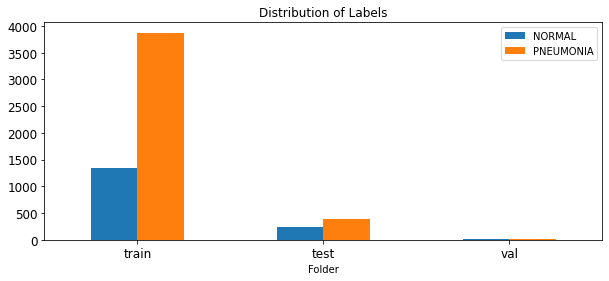

In [5]:
data.plot.bar(x='folder',rot=0,figsize=(10,4),title='Distribution of Labels',xlabel='Folder',fontsize='large')

In [6]:
norm = sum(data["NORMAL"])
sick = sum(data["PNEUMONIA"])

print(f'Healthy patients: {norm} (in total)')
print(f'Sick patients: {sick} (in total)')

Healthy patients: 1583 (in total)
Sick patients: 4273 (in total)


### Reorganize train-val split

As we were not satisified with the imbalanced train-val split, we decided to redistribute it into an 80-20 train-val split.

### Distribution of Labels

<AxesSubplot:title={'center':'Distribution of Labels'}, xlabel='Folder'>

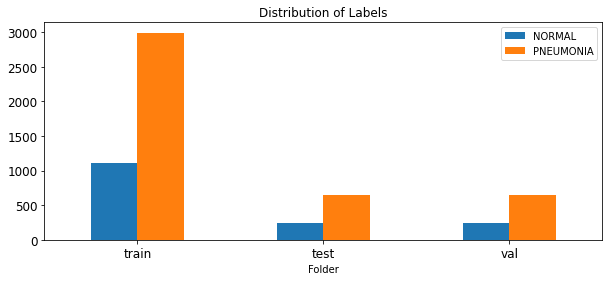

In [8]:
data.plot.bar(x='folder',rot=0,figsize=(10,4),title='Distribution of Labels',xlabel='Folder',fontsize='large')

We notice that there is a significant class imbalance. There many more Pneunomia samples than healthy ones. We resorderd the full data set since we wantet to decreas the trainings data and increase the testing and validation data such that we have good generalization. (We never trained on  thevalidaiton nor the testing data.)

### Create Dataset and DataLoaders

The images are resized to 224x224 and all images are reduced to gray scale. <br>
We use the pytorch Dataset class to load and transform the images to tensors.

In [9]:
class XRayDataset(Dataset):

    def __init__(self, dataset, data, equalize=True, size = 224, labels=None):
        
        self.path = f'chest_xray_re/{dataset}/'
        self.file = data['path']
        self.label = data['label']
        self.len = data.shape[0]
        self.size = size
        self.transform = T.Compose([T.ToTensor(),T.Resize((self.size, self.size))])
        self.equalize = equalize
        
        self.labels = labels

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        
        label = torch.tensor(self.label.iloc[idx]).reshape(-1).to(torch.float32)
        if self.labels is not None:
            label = torch.tensor(self.labels[idx]).reshape(-1).to(torch.float32)

        f = self.path + self.file.iloc[idx]
        image = Image.open(f)
        image_tensor = self.transform(image)
        
        if image_tensor.shape == (3,self.size,self.size):
            data_tensor = 0.299*image_tensor[0,:,:]+0.587*image_tensor[1,:,:]+0.114*image_tensor[2,:,:]
            data_tensor = torch.unsqueeze(data_tensor,dim=0)
        else:
            data_tensor = image_tensor
            
        if self.equalize:
            data_tensor_numpy = (data_tensor.numpy() * 255).astype(np.uint8)
            data_tensor_numpy = data_tensor_numpy[0]
            data_tensor_equalized = cv.equalizeHist(data_tensor_numpy)
            data_tensor = torch.tensor(data_tensor_equalized, dtype=torch.float32) / 255.0
            data_tensor = torch.unsqueeze(data_tensor,dim=0)
            
        return data_tensor, label

In [10]:
# returns DataLoader for specific dataset
def get_loaders(dataset, batch_size=42, equalize=True, shuffle=True, labels=None):
    
    path = f'chest_xray_re/{dataset}.csv'
    data = pd.read_csv(path)
    
    train_dataset = XRayDataset(dataset, data, equalize=equalize, labels=labels)
    loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=0)
    
    return loader

### Visual Difference between healthy and disease samples

Load 5 healthy and 5 pneunomia images.

In [11]:
viz_loader = get_loaders(dataset="test", batch_size=1, equalize=False, shuffle=False)
pneunomia = torch.empty((0, 1, 224, 224))
normal = torch.empty((0, 1, 224, 224)) 
for sample, label in viz_loader:
    if label == 1 and pneunomia.shape[0] < 5:
        pneunomia = torch.cat((pneunomia, sample))
    elif label == 0 and normal.shape[0] < 5:
        normal = torch.cat((normal, sample))
  
    if pneunomia.shape[0] == 5 and normal.shape[0] == 5:
        break

/Users/svlg/opt/anaconda3/envs/Genomics/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


### 5 Healthy Samples vs 5 Pneunomia Samples

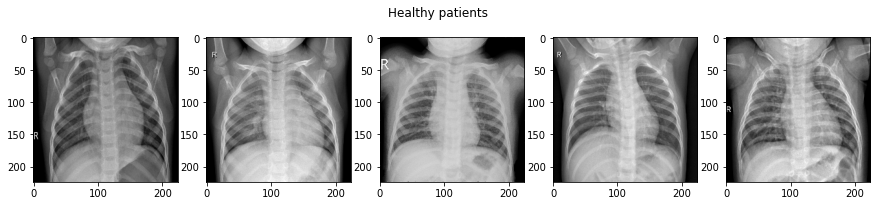

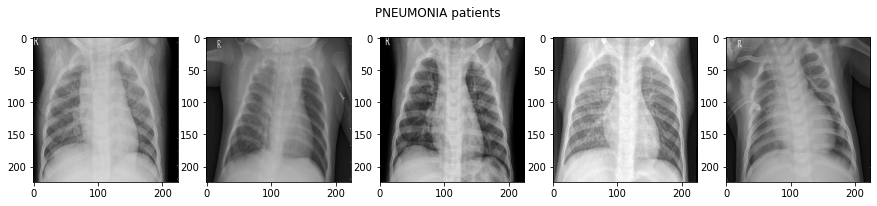

In [12]:
plt.rcParams["figure.figsize"] = (15,3)
fig, ax = plt.subplots(1, 5)
fig.suptitle("Healthy patients")

for img, axis in zip(normal, ax):
    original_image = np.transpose(img.cpu().detach().numpy(), (1, 2, 0))
    axis.imshow(original_image, cmap='gray')
    
fig2, ax2 = plt.subplots(1, 5)
fig2.suptitle("PNEUMONIA patients")
    
for img, axis in zip(pneunomia, ax2):
    original_image = np.transpose(img.cpu().detach().numpy(), (1, 2, 0))
    axis.imshow(original_image, cmap='gray')

plt.show()

### Do you see visual differences between healthy and disease samples?

We can notice bronchi are more visible for the disease examples. Probably because of liquid accumulation.

### Do you find sources of bias that could influence model performance?

We notice that the strength of the contrast varies between different pictures. Therefore we apply histogram equalization as a preprocessing step. For 5 different samples we show the pictures before and after histogram equalization. There is a notable difference and now the images can be better compared.

### Histogram Equalization

In [13]:
samples = torch.empty((0, 1, 224, 224)) 
for sample, label in viz_loader:
    samples = torch.cat((samples,sample))
    if samples.shape[0] == 5:
        break

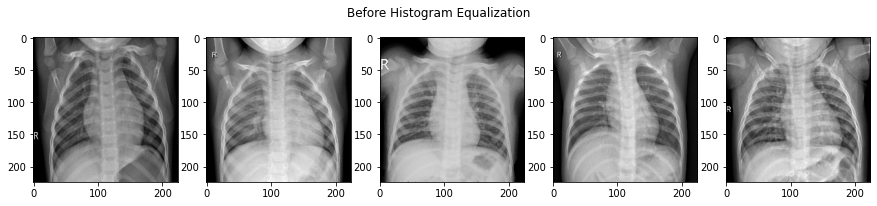

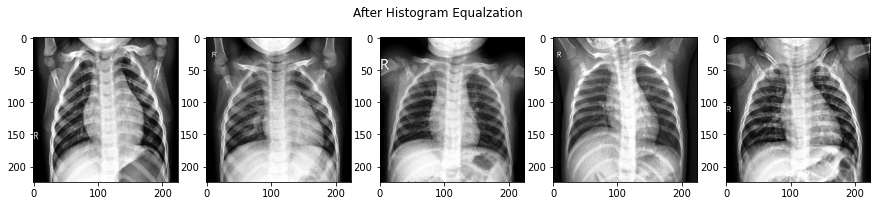

In [14]:
plt.rcParams["figure.figsize"] = (15,3)
fig, ax = plt.subplots(1, 5)
fig.suptitle("Before Histogram Equalization")

for img, axis in zip(samples, ax):
    original_image = np.transpose(img.cpu().detach().numpy(), (1, 2, 0))
    axis.imshow(original_image, cmap='gray')

plt.rcParams["figure.figsize"] = (15,3)
fig2, ax2 = plt.subplots(1, 5)
fig2.suptitle("After Histogram Equalzation")

for img, axis in zip(samples, ax2):
    original_image = (img.cpu().detach().numpy() * 255).astype(np.uint8)
    original_image = original_image[0]
    original_image = cv.equalizeHist(original_image)
    axis.imshow(original_image, cmap='gray')

plt.show()

## Q2: CNN Classifier

### Model architecture

We use a small size VGG model:

In [15]:
class VGG_small(nn.Module):
    def __init__(self):
        super(VGG_small, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(7*7*512, 3072),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(3072, 3072),
            nn.ReLU())
        self.fc2 = nn.Sequential(
            nn.Linear(3072, 1))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer13(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

### Evaluation and Training Loops

We define one loop for evaluation and training each.

We use Balanced Accuracy and F1-Score as training and testing metrics. <br>
F1 because we want to account for the model imbalance between healthy and sick patients.

In [16]:
def evaluate(model, loss_fn, val_loader, device):
    # goes through the validation dataset
    # computes the Accuracy and F1-score
    
    model.eval()

    with torch.no_grad():
        
        avg_val_loss, val_loss = 0, 0
        num_eval_samples, correct = 0, 0
        y_pred, y_true = [],[]
        
        for x_batch, y_batch in tqdm(val_loader, desc=f'Evaluation', ncols = 100, leave=True):    
            
            # push to cuda
            y_batch = y_batch.to(device)
            x_batch = x_batch.to(device)

            # make a predition
            y_hat = model.forward(x_batch)
            
            # loss
            loss = loss_fn(y_hat, y_batch)

            # keep track of validation stats
            num_samples_batch = x_batch.shape[0]
            num_eval_samples += num_samples_batch
            val_loss += loss.item() * num_samples_batch
            y_true.append(y_batch.cpu().numpy().reshape(num_samples_batch))
            y_pred.append(torch.round(F.sigmoid(y_hat)).cpu().numpy().reshape(num_samples_batch))
        
        y_true = np.hstack(y_true).reshape(num_eval_samples)
        y_pred = np.hstack(y_pred).reshape(num_eval_samples)
        avg_val_loss = val_loss / num_eval_samples
        acc = accuracy_score(y_true,y_pred)
        f1 = f1_score(y_true, y_pred)
        return avg_val_loss, acc, f1

In [17]:
def train_loop(model, train_loader, val_loader, loss_fn, optim, device, show=2, save=5, epochs=20):
    
    # Some settings
    best_epoch = 0
    best_acc = 0
    print(f'Start training model')
    
    for epoch in range(1,epochs+1):
        # reset statistics trackers
        train = 0.0
        num_samples_epoch = 0
        train_loss_cum = torch.tensor([0.])
        
        # put model intro train mode
        model.train()
        
        pbar = tqdm(train_loader, desc=f'Training [{epoch}/{epochs}]', ncols = 100, leave=True)

        # Go once through the training dataset (-> epoch)
        for x_batch, y_batch in pbar:

            # push to cuda
            y_batch = y_batch.to(device)
            x_batch = x_batch.to(device)

            # zero grads
            optim.zero_grad()
            
            # forward pass though the model
            y_hat = model.forward(x_batch)
            
            # loss
            loss = loss_fn(y_hat, y_batch)
            
            # backward pass and gradient step
            loss.backward()
            optim.step()
            
            # keep track of train stats
            num_samples_batch = x_batch.shape[0]
            num_samples_epoch += num_samples_batch
            train_loss_cum += loss.item() * num_samples_batch


        # average the accumulated train statistics
        avg_train_loss = train_loss_cum / num_samples_epoch

        # get a validation
        val_loss, val_acc, val_f1 = evaluate(model, loss_fn, val_loader, device)

        # print some trainings infos
        print(f'\n'
              f'Epoch {epoch}\n'
              f'Train-loss: {avg_train_loss.item():.5f} | Val-loss: {val_loss:.5f}\n'
              f'Accuracy:   {val_acc*100:.3f}% | F1-Score: {val_f1:.5f}', flush=True)

        # save checkpoint of model
        if epoch % save == 0 and epoch > 2:
            save_path = f'/content/drive/MyDrive/MLHC_P1/chest_xray_re/model_epoch_{epoch}_vgg_small.pt'
            torch.save(model.state_dict(), save_path)
            print(f'Saved model checkpoint to {save_path}\n', flush=True)

        if best_acc < val_acc and epoch > 2:
            best_acc = val_acc
            best_epoch = epoch
            save_path = f'/content/drive/MyDrive/MLHC_P1/chest_xray_re/model_best_vgg_small.pt'
            torch.save(model.state_dict(), save_path)
            print(f'Saved model best in epoch {epoch} to checkpoint {save_path}\n', flush=True)


    print(f'Best Accuracy: {best_acc:.5f} in Epoch {best_epoch}')

In [19]:
model = VGG_small().to(device)

### Loss and Optimizer Function

In [20]:
loss_fn = nn.BCEWithLogitsLoss()
optim = torch.optim.Adam(model.parameters(), lr=5e-4)

### Training or loading a model

Get the data loaders.

In [21]:
train_loader = get_loaders(dataset="train")
val_loader   = get_loaders(dataset="val", shuffle=False)
test_loader  = get_loaders(dataset="test", batch_size=4, shuffle=False)

We trained the model on google colab using the train loop function. <br>
We then we saved it and reloaded it if needed.

In [22]:
USE_PRETRAINED_MODEL = True

if USE_PRETRAINED_MODEL:
    model.load_state_dict(torch.load('chest_xray_re/model_best_vgg_small_eq.pt',map_location=device))
    print("Using existing trained model")
    model.eval()
else:
    train_loop(model, train_loader, val_loader, loss_fn, optim, device)
            # Epoch 20
            # Train-loss: 0.05350 | Val-loss: 0.11790
            # Accuracy:   95.672% | F1-Score: 0.97077

            # Best Accuracy: 0.96241 in Epoch 19

    print('Finished Training')

Using existing trained model


In [23]:
def test(model, loader, device):
    # goes through the validation dataset
    # computes the Accuracy and F1-score
    
    model.eval()

    with torch.no_grad():
        num_eval_samples, correct = 0, 0
        y_pred, y_true = [],[]
        
        for x_batch, y_batch in tqdm(loader, desc=f'Test', ncols = 100, leave=True):    
            
            # push to cuda
            y_batch = y_batch.to(device)
            x_batch = x_batch.to(device)

            # make a predition
            y_hat = model.forward(x_batch)

            # keep track of validation stats
            num_samples_batch = x_batch.shape[0]
            num_eval_samples += num_samples_batch
            y_true.append(y_batch.cpu().numpy().reshape(num_samples_batch))
            y_pred.append(torch.round(torch.sigmoid(y_hat)).cpu().numpy().reshape(num_samples_batch))
        
        y_true = np.hstack(y_true).reshape(num_eval_samples)
        y_pred = np.hstack(y_pred).reshape(num_eval_samples)
        return y_true, y_pred
    
y_true, y_pred = test(model, test_loader, device)

Test:   0%|                                                                 | 0/220 [00:00<?, ?it/s]/Users/svlg/opt/anaconda3/envs/Genomics/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Test: 100%|███████████████████████████████████████████████████████| 220/220 [01:38<00:00,  2.24it/s]


### Evaluation

In [39]:
acc = balanced_accuracy_score(y_true,y_pred)
f1 = f1_score(y_true, y_pred)
print(f'Balanced Accuracy: {acc:.3f}%')
print(f'F1-Score: {f1:.3f}%')

Balanced Accuracy: 0.942%
F1-Score: 0.975%


## Q3: Integrated Gradients

Load 5 healthy and 5 pneunomia images.

In [25]:
viz_loader = get_loaders(dataset="test", batch_size=1, shuffle=False)
pneunomia = torch.empty((0, 1, 224, 224))
normal = torch.empty((0, 1, 224, 224)) 
for sample, label in viz_loader:
    if label == 1 and pneunomia.shape[0] < 5:
        pneunomia = torch.cat((pneunomia, sample))
    elif label == 0 and normal.shape[0] < 5:
        normal = torch.cat((normal, sample))
  
    if pneunomia.shape[0] == 5 and normal.shape[0] == 5:
        break

/Users/svlg/opt/anaconda3/envs/Genomics/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Apply integrated gradients to the 5 positive and 5 negative samples from Q1.

In [26]:
ig = IntegratedGradients(model)
pneunomia_attr = []
normal_attr = []

for i in tqdm(range(5)):
  
    attr_ig = ig.attribute(torch.unsqueeze(pneunomia[i], dim=0).to(device), baselines=0, return_convergence_delta=False)
    pneunomia_attr.append(np.transpose(attr_ig.squeeze(0).cpu().detach().numpy(), (1, 2, 0)))

    attr_ig = ig.attribute(torch.unsqueeze(normal[i], dim=0).to(device), baselines=0, return_convergence_delta=False)
    normal_attr.append(np.transpose(attr_ig.squeeze(0).cpu().detach().numpy(), (1, 2, 0)))

100%|██████████████████████████████████████████████████████████████████████████| 5/5 [02:03<00:00, 24.75s/it]


### Plot 5 positive samples and 5 negative samples

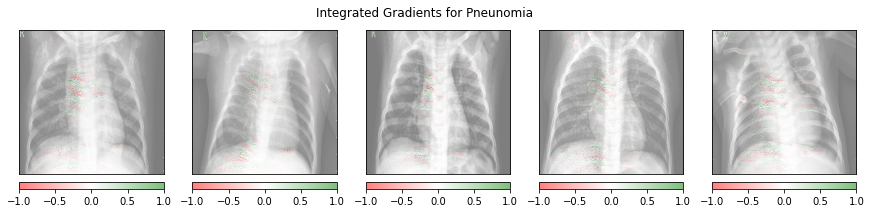

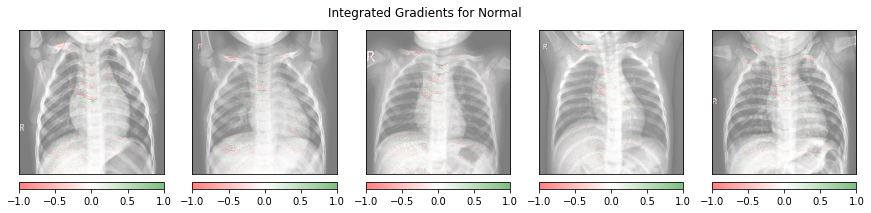

In [27]:
plt.rcParams["figure.figsize"] = (15,3)
fig, ax = plt.subplots(1, 5)
fig.suptitle("Integrated Gradients for Pneunomia")

for attr, img, axis in zip(pneunomia_attr, pneunomia, ax):

    original_image = np.transpose(img.cpu().detach().numpy(), (1, 2, 0))
    _ = viz.visualize_image_attr(attr, original_image, method="blended_heat_map",sign="all",
                            show_colorbar=True, plt_fig_axis=(fig, axis), use_pyplot=False)
    
fig2, ax2 = plt.subplots(1, 5)
fig2.suptitle("Integrated Gradients for Normal")

for attr, img, axis in zip(normal_attr, normal, ax2):

    original_image = np.transpose(img.cpu().detach().numpy(), (1, 2, 0))
    _ = viz.visualize_image_attr(attr, original_image, method="blended_heat_map",sign="all",
                            show_colorbar=True, plt_fig_axis=(fig, axis), use_pyplot=False)

plt.show()

### Do the maps highlight sensible regions?

The integrated gradients do not highlight sensible regions. High contrast regions, such as edges between bones and tissue are marked. These are not sensible for our particular task and we can not make out any difference in the integrated gradients for normal and disease samples.

### Are attributions consistent across samples?

The attributions are similar across samples, in that they highlight similar regions. There are some variations, for example in normal samples we see some integrated gradients on the shoulder bones.

### Do they match potential observations from Q1?

No, we cannot see a highlighting of abnormalities using the integrated gradients.

## Q4: Grad-CAM

In [28]:
target_layers = model.layer13
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=use_cuda)

In [29]:
pneunomia_cam = cam(input_tensor=pneunomia)
normal_cam = cam(input_tensor=normal)

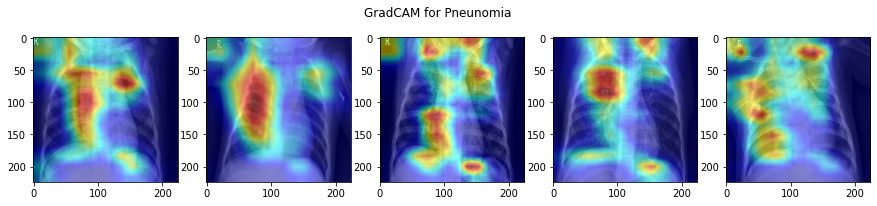

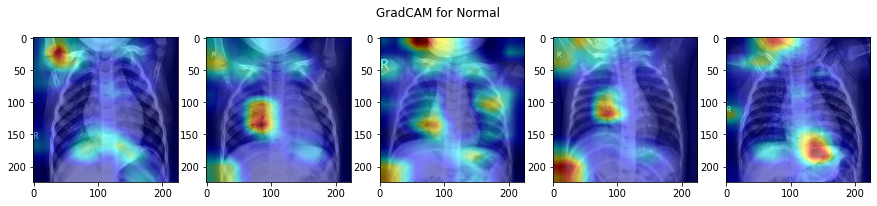

In [30]:
plt.rcParams["figure.figsize"] = (15,3)
fig, ax = plt.subplots(1, 5)
fig.suptitle("GradCAM for Pneunomia")

for gray_cam, img, axis in zip(pneunomia_cam, pneunomia, ax):
    original_image = np.transpose(img.cpu().detach().numpy(), (1, 2, 0))
    visualization = show_cam_on_image(original_image, gray_cam, use_rgb=True)
    axis.imshow(visualization)
    
fig2, ax2 = plt.subplots(1, 5)
fig2.suptitle("GradCAM for Normal")

for gray_cam, img, axis in zip(normal_cam, normal, ax2):
    original_image = np.transpose(img.cpu().detach().numpy(), (1, 2, 0))
    visualization = show_cam_on_image(original_image, gray_cam, use_rgb=True)
    axis.imshow(visualization)
    
plt.show()

### Do the maps highlight sensible regions?

In the case of the pneunomia samples, viewing the pictures we can see the GradCAM highlights regions left of the heart.
This makes sense, because the heart tends to cover the bronchi of the right making it impossible for the detection of fluid and thereby the detection of pneumonia by the xray.  


### Are attributions consistent across samples?

One could say that the attributions seem to be quite consistent within one class. Especially in the pneumonia class one can find highlighted areas more oftenly. Furthermore, in the pneumonia cases one can clearly conclude systematic highlights of the regions of interests whereas in the normal samples highlighted areas seem to be rather random and more evenly spread across the xray image. 

## Q5: Data Randomization Test

In [31]:
model_perturbed = VGG_small().to(device)

We did not manage to finish Q5 fully:

### Permute the labels

First we extract the labels and the we permute them. <br>
After that we pass them directly to the dataset.

In [32]:
class LabelDataset(Dataset):

    def __init__(self, data):
        
        self.path = f'chest_xray_re/train/'
        self.label = data['label']
        self.len = data.shape[0]
        
    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        label = torch.tensor(self.label.iloc[idx]).reshape(-1).to(torch.float32)
            
        return label

In [33]:
path = f'chest_xray_re/train.csv'
data = pd.read_csv(path)
dataset = LabelDataset(data)
labelloader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=0)

In [34]:
labels = torch.empty((0, 1))
for label in labelloader:
    labels = torch.cat((labels,label))

In [35]:
labels = torch.squeeze(labels).numpy()

In [36]:
shuffled_labels = labels.copy()
np.random.shuffle(shuffled_labels)

Now we have the shuffled labels in shuffled_labels.

In [37]:
shuffled_train_loader = get_loaders(dataset="train", labels=shuffled_labels)

In [38]:
train_loop(model_perturbed, shuffled_train_loader, val_loader, loss_fn, optim, device)

Start training model


Training [1/20]:   0%|                                                       | 0/98 [00:00<?, ?it/s]/Users/svlg/opt/anaconda3/envs/Genomics/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Training [1/20]:   1%|▍                                              | 1/98 [00:18<30:32, 18.90s/it]


KeyboardInterrupt: 

### Retrain your CNN on random training labels and perform the Data randomization Test for both Integrated Gradients and Grad-CAM. Do they pass or fail?